# Unit Testing Optimisation

## Importing the Packages

In [245]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial
from itertools import chain

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_multimap, tree_map, devices

import time

In [246]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [247]:
num_mach = 1

## Defining SE Covariance

In [248]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [249]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Creating Test Data

In [250]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [251]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [252]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 20.0
batch_size = 1
num_filt = num_mach * batch_size
# Maximum index of input data
n = np.floor(x_maxt/time_bin).astype(np.int64)

ytime = np.linspace(0.0, x_maxt, n + 1).reshape(n + 1, 1)

spikedat = random.bernoulli(subkeyx, 0.1, (num_filt * (n + 1),)).astype(np.float64).reshape(num_filt, n + 1, 1)

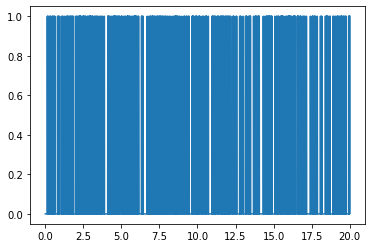

In [253]:
plt.plot(ytime, spikedat.flatten())

### True Filter

In [254]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.0

# Maximum index of filter data
k = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, k + 1).reshape(k + 1, 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = (np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true).reshape(k + 1, 1)

num_filt = 1

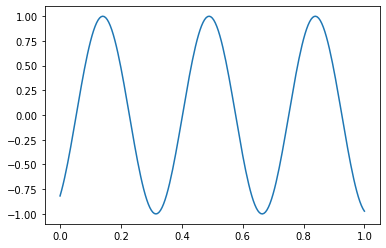

In [255]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

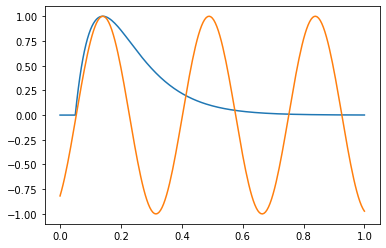

In [256]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

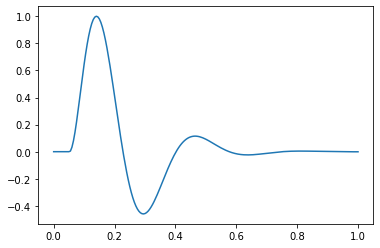

In [257]:
plt.plot(ftime, ftrue)

### True Noise

In [258]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (n + 1, 1))

### Output

In [259]:
# Padding and applying the FFT
spikepad = np.hstack((spikedat, np.zeros((num_filt, k, 1))))
fpad = np.vstack((ftrue.reshape((k + 1, 1)), np.zeros((n, 1))))

spikefft = np.fft.rfft(spikepad, axis = 1)
fftlen = np.shape(spikefft)[1]
spikefft = spikefft.reshape(num_mach, batch_size, fftlen, 1)

f_fft = np.fft.rfft(fpad, axis = 0)

fftmul = spikefft * f_fft

ynonoise = np.fft.irfft(fftmul, k + n + 1, axis = -2)[:, :, :n + 1]
yvel = (ynonoise + noise_vec).reshape(n + 1, 1)

In [260]:
# Showing equals the raw convolution
yffttest = np.convolve(spikedat.flatten(), ftrue.flatten())[:n + 1] + noise_vec.flatten()

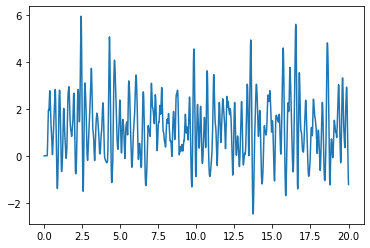

In [261]:
plt.plot(ytime, ynonoise.flatten())

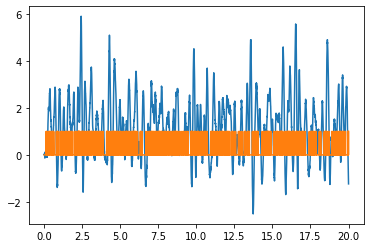

In [262]:
plt.plot(ytime, yvel.flatten())
plt.plot(ytime, spikedat.flatten())

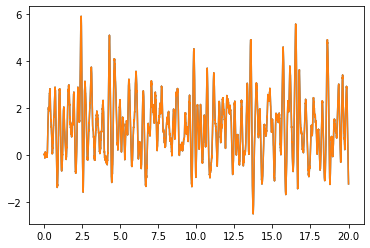

In [263]:
plt.plot(ytime, yffttest.flatten())
plt.plot(ytime, yvel.flatten())

In [264]:
print(spikefft.shape)
print(ytime.shape)
print(yvel.shape)

(1, 1, 2101, 1)
(4001, 1)
(4001, 1)


## Variational Inference

### ELBO

#### Kl Divergence Term

In [265]:
@jit
def KL_Term(L_Matrix, V_Vector, Num_Filt, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Num_Filt * M)

In [266]:
test_key = random.PRNGKey(0)
test_m = int(20)
test_l_mm = random.uniform(test_key, (num_mach, batch_size, test_m, test_m))
test_v_m = random.uniform(test_key, (num_mach, batch_size, test_m, 1))

In [267]:
print(KL_Term(test_l_mm[0], test_v_m[0], batch_size, test_m))

75.0861942481935


In [268]:
PmapKL = pmap(KL_Term, in_axes=(0, 0, None, None))

In [269]:
klguess = PmapKL(test_l_mm, test_v_m, batch_size, test_m)

In [270]:
print(np.sum(klguess))

75.0861942481935


#### Batch Predictions

In [271]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [272]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [273]:
@partial(jit, static_argnums = range(8,14))
def Batch_Pred(Sigma_f, Ell, Z_Vector, V_Vector, L_Matrix, TRise,
                TauDiff, Lag, Number_F, Num_Base, M, Batch_Size, K, N, Spike_Fft, Velocity,
                F_Time, Subkeys):

  Thetas = random.normal(Subkeys[0], (Number_F, Batch_Size, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (Number_F, Batch_Size, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Batch_Size, Num_Base, 1))

  Constant = (Sigma_f * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Batch_Size, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise, TauDiff, Lag)

  F_Samples = jnp.dstack((F_Samples, jnp.zeros((Number_F, Batch_Size, N, 1))))

  F_Fft = jnp.fft.rfft(F_Samples, axis = -2)

  Filter_Out = jnp.fft.irfft(F_Fft * Spike_Fft, N + K + 1, axis = -2)[:, :, : N + 1]
  
  return jnp.sum(Filter_Out, axis = 1)

In [274]:
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_number_f = 50
test_num_base = 100
test_m = int(20)

test_sigma_f = 5.0 * np.ones((batch_size, 1, 1))#np.linspace(0.01, 4.0, batch_size).reshape((batch_size, 1, 1))
test_ell_f = 2.0 * np.ones((batch_size, 1, 1))#np.linspace(0.01, 2.0, batch_size).reshape((batch_size, 1, 1))
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), 
                        (batch_size, 1, 1))
test_v_m = np.zeros(test_m * batch_size).reshape((batch_size, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (batch_size, 1, 1))
test_trise = 0.2 * np.ones((batch_size, 1, 1))
test_tdiff = 0.5 * np.ones((batch_size, 1, 1))
test_lag = 0.01 * np.ones((batch_size, 1, 1))

print(test_subkeys)

[[[1836460763  990488084]
  [1416732029 1887795613]
  [1078027127 1191019179]
  [3297765038 3069809391]]]


In [275]:
samps = Batch_Pred(test_sigma_f, test_ell_f, test_z_m, 
              test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, 
              test_num_base, test_m, batch_size, k, n,
              spikefft[0], yvel, ftime, test_subkeys[0])

In [276]:
print(samps.shape)

(50, 4001, 1)


#### Total Predictions

In [277]:
Pred = pmap(Batch_Pred, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, 0, None, None, 0,),
              static_broadcasted_argnums=range(8, 14))

In [278]:
test_sigma_f = 5.0 * np.ones((num_mach, batch_size, 1, 1))#np.linspace(0.01, 4.0, num_filt).reshape((num_mach, batch_size, 1, 1))
test_ell_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))#np.linspace(0.01, 2.0, num_filt).reshape((num_mach, batch_size, 1, 1))
test_sigma_n = 0.05
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), 
                        (num_mach, batch_size, 1, 1))
test_v_m = np.zeros(test_m * num_filt).reshape((num_mach, batch_size, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_mach, batch_size, 1, 1))
test_trise = 0.2 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.5 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))

In [279]:
totalsamps = Pred(test_sigma_f, test_ell_f, test_z_m, 
              test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, 
              test_num_base, test_m, batch_size, k, n,
              spikefft, yvel, ftime, test_subkeys)

In [280]:
totalpreds = np.sum(totalsamps, axis = 0)

In [281]:
test_likelihoods = - 0.5 * ((n + 1) * jnp.log(2 * jnp.pi * test_sigma_n ** 2) + \
                    jnp.sum((yvel - totalpreds)**2, axis = 1)/(test_sigma_n ** 2))

In [282]:
print(np.mean(test_likelihoods))

-1448264390.269478


#### ELBO

In [283]:
Diag = pmap(vmap(jnp.diag))

In [284]:
@jit
def SetOff(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [285]:
Set = pmap(SetOff, in_axes=(0, None, 0,))

In [286]:
@partial(jit, static_argnums = range(10, 17))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):
         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag) + Lag

  D = Diag(jnp.exp(L_Diag))

  L_Matrix = Set(D, Indices, L_ODiag)

  KLmap = PmapKL(L_Matrix, V_Vector, Batch_Size, M)

  Predictions = Pred(Sigma_f, Ell, Z_Vector, V_Vector, L_Matrix, TRise,
                TauDiff, Lag, Number_F, Num_Base, M, Batch_Size, K, N, Spike_Fft, Velocity,
                F_Time, Subkeys)
  
  Likelihoods = - 0.5 * ((N + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Velocity - Predictions)**2, axis = 2)/(Sigma_n ** 2))

  KL = jnp.sum(KLmap)
  Exp = jnp.mean(Likelihoods)
                  
  return (KL-Exp)/(Num_Filt + N + 1)

In [287]:
test_number_f = 15
test_num_base = 100
test_m = int(20)

test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = jnp.asarray(test_subkeys).astype(jnp.uint32).reshape(num_mach, 4, 2)

test_sigma_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))# np.arange(num_mach * batch_size).reshape(num_mach, batch_size, 1, 1)
test_ell_f = 0.7 * np.ones((num_mach, batch_size, 1, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_mach, batch_size, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_mach, batch_size, test_m, 1))
test_l_diag = np.ones((num_mach, batch_size, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_mach, batch_size, 1))
test_trise = 0.02 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.03 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))
test_indices = np.tril_indices(test_m, -1)

In [288]:
nelbo = Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                    test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag,
                    test_number_f, test_num_base, test_m, num_filt, batch_size,
                    k, n, test_indices, spikefft, yvel, ftime, test_subkeys)

In [289]:
print(nelbo)

15017.495656433744


In [290]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 17))

In [291]:
print(Grad_Bound(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                    test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag,
                    test_number_f, test_num_base, test_m, num_filt, batch_size,
                    k, n, test_indices, spikefft, yvel, ftime, test_subkeys))

(DeviceArray(15017.49565643, dtype=float64), (DeviceArray([[[[-132.09983202]]]], dtype=float64), DeviceArray([[[[4.34854958]]]], dtype=float64), DeviceArray(-3004116.7835747, dtype=float64, weak_type=True), DeviceArray([[[[ 6.18494149e-14],
               [ 2.43349096e+00],
               [-6.27988202e-01],
               [-1.13891260e-01],
               [ 3.30937992e-01],
               [ 2.01071528e-01],
               [-5.81949535e-02],
               [ 6.36427034e-02],
               [-1.39574540e-01],
               [-1.84448798e-01],
               [-1.68863954e-01],
               [ 4.94651878e-02],
               [ 5.37130313e-02],
               [ 1.12474937e-01],
               [ 8.94772540e-02],
               [ 5.70667394e-02],
               [ 6.93340480e-02],
               [-3.09921231e-02],
               [-2.40993110e-02],
               [ 3.13341431e-18]]]], dtype=float64), DeviceArray([[[[-7.82943029e+01],
               [-5.66123992e-01],
               [ 2.9727134

### Optimiser

#### Sub-function Definitions

In [292]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [293]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [294]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [295]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [296]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [297]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [298]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [299]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(CFinState, X, Mhat, Vhat)

  return X, M, V

In [300]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(MFinState, X, Mhat, Vhat)

  return X, M, V

In [301]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(FFinState, X, Mhat, Vhat)

  return X, M, V

In [302]:
@partial(jit, static_argnums = range(8, 16))
def _CUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Coarse_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
              Spike_Fft, Velocity, F_Time):
              
  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [303]:
@partial(jit, static_argnums = range(8, 16))
def _MUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Mid_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
              Spike_Fft, Velocity, F_Time):

  Value, Grads = Grad_Bound(*X, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [304]:
@partial(jit, static_argnums = range(8, 16))
def _FUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, 
              Num_Fine_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
              Spike_Fft, Velocity, F_Time):

  Value, Grads = Grad_Bound(*X, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [305]:
@partial(jit, static_argnums = range(1, 9))
def AdamOpt(Init_Params, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
              Spike_Fft, Velocity, F_Time, Coarse_Schedule = jnp.asarray([1500]), 
              Mid_Schedule = jnp.asarray([16500]), Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(0)
  Key, *Subkeys = random.split(Key, 1 + 4 * Num_Mach)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(Num_Mach, 4, 2)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
                      Spike_Fft, Velocity, F_Time)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
                      Spike_Fft, Velocity, F_Time)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Num_Fs, Num_Base, M, Num_Filt, Num_Mach, Batch_Size, K, N, Indices, 
                      Spike_Fft, Velocity, F_Time)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, 
                              (Params, Subkeys, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [306]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 5.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

# Variational parameters
num_f = 50
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.tril_indices(num_ind, -1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 1 + 4 * num_mach)
opt_subkey = jnp.asarray(opt_subkey).astype(jnp.uint32).reshape(num_mach, 4, 2)
print(opt_subkey)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, ftime)
print(params)

[[[ 532076793 2354449600]
  [1813813011 1313272271]
  [3522235465 4107438537]
  [1531693580 2391939978]]]
(DeviceArray([[[[5.]]]], dtype=float64), DeviceArray([[[[0.002]]]], dtype=float64), 5e-06, DeviceArray([[[[0.        ],
               [0.14736307],
               [0.21035359],
               [0.26014694],
               [0.30346367],
               [0.34292381],
               [0.37989849],
               [0.41523598],
               [0.44952933],
               [0.4832391 ],
               [0.5167609 ],
               [0.55047067],
               [0.58476402],
               [0.62010151],
               [0.65707619],
               [0.69653633],
               [0.73985306],
               [0.78964641],
               [0.85263693],
               [1.        ]]]], dtype=float64), DeviceArray([[[[-0.00673253],
               [ 0.01577649],
               [ 0.0044755 ],
               [ 0.00527054],
               [-0.0062202 ],
               [ 0.00995639],
               [-0.00271

In [307]:
fparams, elbo_history = AdamOpt(params, num_f, num_b, num_ind, num_filt, num_mach, batch_size,
                                  k, n, indices, spikefft, yvel, ftime)

In [308]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [309]:
print(Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey))

1012717483358.1307


In [310]:
# ffttest = Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey)
# liketest = - 0.5 * ((n + 1) * jnp.log(2 * jnp.pi * isigma_n ** 2) + \
#                  jnp.sum((yvel - ffttest)**2, axis = -2)/(isigma_n ** 2))
# print((liketest).shape)
# testl = Set(Diag(jnp.exp(il_diag)), indices, il_odiag)
# kltest = PmapKL(testl, iv_vector, batch_size, num_ind)
# print(kltest[0])
# print(((kltest - np.mean(liketest))/(num_filt + n + 1))[0])
# print(Neg_ELBO(*fparams, num_f, num_b, *consparams, opt_subkey))

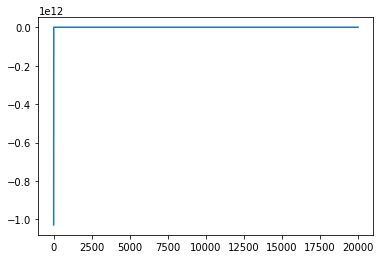

In [311]:
plt.plot(elbo_history[:])

In [312]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [313]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = Diag(np.exp(il_diag))
il_matrix = Set(idz, indices, il_odiag)


flag = flag ** 2

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = Diag(np.exp(fl_diag))
fl_matrix = Set(fd, indices, fl_odiag)

In [314]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

fsigma_ff = fsigma_f.reshape(num_filt, 1)
fellf = fell.reshape(num_filt, 1)
fz_vectorf = fz_vector.reshape(num_filt, num_ind, 1)
fv_vectorf = fv_vector.reshape(num_filt, num_ind, 1)
fl_matrixf = fl_matrix.reshape(num_filt, num_ind, num_ind)
ftrisef = ftrise.reshape(num_filt, 1)
ftaudifff = ftaudiff.reshape(num_filt, 1)
flagf = flag.reshape(num_filt, 1)

spikefftf = spikefft.reshape(num_filt, fftlen, 1)

In [315]:
print(fsigma_ff)

[[3.5436152]]


In [316]:
print(fellf)

[[-0.10706718]]


In [317]:
print(fsigma_n)

0.05053948732014949


In [318]:
print(ftrisef)

[[0.15493859]]


In [319]:
print(ftaudifff)

[[0.24043043]]


In [320]:
print(flagf)

[[0.05313406]]


## Variational Predictions

In [321]:
fpred_points = ftime.copy()

In [322]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [323]:
scfsigmaf = fsigma_ff[:, None]
scfellf = fellf[:, None]
scftrisef = ftrisef[:, None]
scftaudifff = ftaudifff[:, None]
scflagf = flagf[:, None]

fkmm = Squared_exp(fz_vectorf, fz_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vectorf, fpred_points.T, scfsigmaf, scfellf)
fbzast = np.zeros((num_filt, num_ind, k + 1))
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vectorf)

fkastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [324]:
print(imeanpred.shape)

(1, 201, 1)


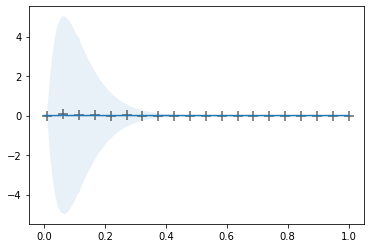

In [325]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

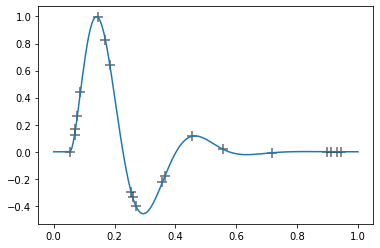

In [326]:
predindenv = AlpEnvelope(fz_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

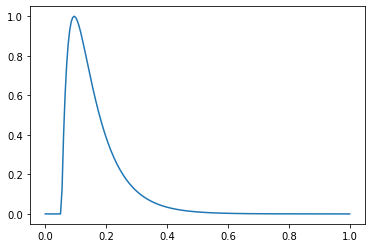

In [327]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

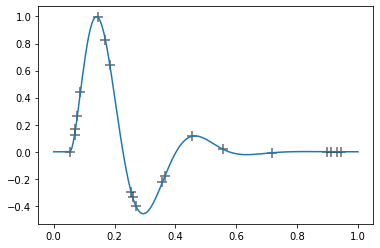

In [328]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

In [329]:
def OUTconvolve(Filters, K, N, Spike_FFT):
  Pad = np.hstack((Filters, np.zeros((num_filt, N, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [330]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, k, n, spikefftf)
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, k, n, spikefftf)
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, k, n, spikefftf)

In [331]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, k, n, spikefftf)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, k, n, spikefftf)
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, k, n, spikefftf)

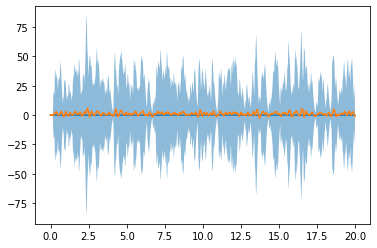

In [332]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, yvel)
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

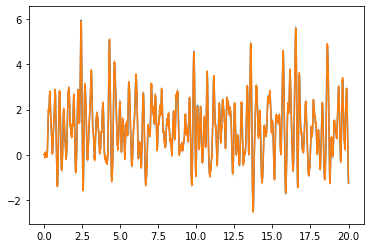

In [333]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, yvel)
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

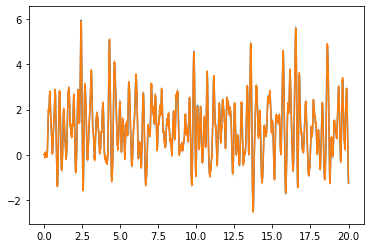

In [334]:
ytesttru = yvel[:20000]
ytimetru = ytime[:20000]
fmeanpredicttru = fmeanpredict[:20000]
fmeanpredictns2tru = fmeanpredictns2[:20000]
fmeanpredictps2tru = fmeanpredictps2[:20000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru)
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)

## Testing Against New Data

In [ ]:
kext = 3000
xnew = data.spikes.to_numpy()[:k + 1 + kext, :num_filt]
ytimenew = (data.index / np.timedelta64(1, 's')).to_numpy()[:k + 1 + kext]
ycoordnew = data.finger_pos.y.to_numpy()[:k + 1 + kext]
xcoordnew = data.finger_pos.x.to_numpy()[:k + 1 + kext]
ytestnew = ycoordnew.reshape(k + 1 + kext, 1)
xnewtes = xnew.T[:, :, None]

ytestnew -= ytestnew[0, 0]
xnew = xnew.T[:,:,None]
print(np.where(xtest != xnewtes[:, :k + 1]))
print(xnew.shape)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(10, 5500, 1)


In [ ]:
ktotal = kext + k

In [ ]:
xnewpad = np.hstack((xnew, np.zeros((num_filt, ktotal, 1))))
xnewfft = np.fft.rfft(xnewpad, n + ktotal + 1, axis = 1)[:, :ktotal + 1]
fnew = OUTconvolve(fmeanpred, n, ktotal, xnewfft)

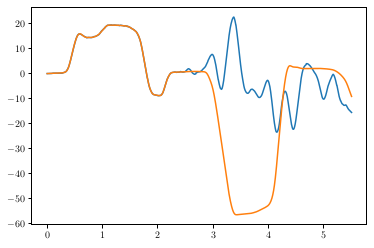

In [ ]:
plt.plot(ytimenew, fnew)
plt.plot(ytimenew, ytestnew)

## $R^2$ Value

### On training data

## Fixing Convolution

In [ ]:
%%capture
fmeanpred # the filter for each spike train
xtest # the original spike data

### One spike train

#### Numpy convolution

In [ ]:
indy = 20 # index of train checking
outindy = np.convolve(xtest[indy].flatten(), fmeanpred[indy].flatten())[:k + 1]

IndexError: index 20 is out of bounds for axis 0 with size 10

In [ ]:
convolutions = np.zeros((num_filt, k + 1))
for i in range(num_filt):
  convolutions[i] = np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1]
prediction = np.sum(convolutions, axis=0)
print(np.shape(prediction))

(80000,)


In [ ]:
print(np.equal(fullindy, prediction))

[ True  True  True ...  True  True  True]


#### FFT convolution

In [ ]:
xindypad = np.vstack((xtest[indy], np.zeros((n, 1))))
xindyfft = np.fft.rfft(xindypad, axis = 0)

findypad = np.vstack((fmeanpred[indy], np.zeros((k, 1))))
findyfft = np.fft.rfft(findypad, axis = 0)
outfftindy = np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0)[:k + 1]

(3.0, 5.0)

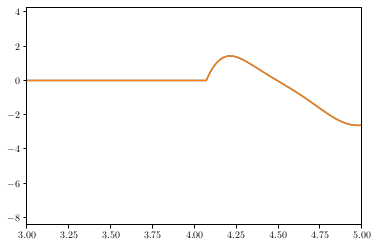

In [ ]:
plt.plot(ytime, outindy)
plt.plot(ytime, outfftindy)
plt.xlim([3.0, 5.0])

In [ ]:
fullindy = np.zeros(k + 1)
fftindy = np.zeros(k + 1)
for i in range(num_filt):
  fullindy += np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1] # np convolution

  xindypad = np.vstack((xtest[i], np.zeros((n, 1))))
  xindyfft = np.fft.rfft(xindypad, axis = 0)

  findypad = np.vstack((fmeanpred[i], np.zeros((k, 1))))
  findyfft = np.fft.rfft(findypad, axis = 0)
  fftindy += np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0).flatten()[:k + 1]

(0.0, 10.0)

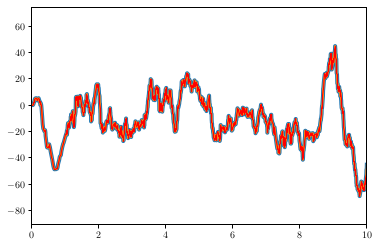

In [ ]:
plt.plot(ytime, fullindy, linewidth = 4.0)
plt.plot(ytime, fftindy, linewidth = 2.0)
plt.plot(ytime, prediction, linewidth = 0.5, color = 'red')
plt.xlim([0.0, 10.0])